In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy as scp
import os
import statistics

plt.style.use('fast')
#plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}

plt.rc('font', **font)

fl = {'probe2_dw': 0.1522e-3,
        'probe2_up': 0.1522e-3,
        'probe3_dw': 0.2419e-3,
        'probe3_up': 0.2419e-3,
        'probe4_dw': 0.2488e-3,
        'probe4_up': 0.2488e-3}

In [79]:
filepaths = ['..\Widerstand']
measurements = {}
for filepath in filepaths:
    for name in os.listdir(filepath):
        if name.endswith('.xlsx'):
            df = pd.read_excel(filepath + '\\' + name)
            arr = np.transpose(df.to_numpy())
            measurements[name.split('.')[0]] = arr

probe2_up [3.48689709e-04 1.68856665e-06]
0.0003877744728170687 9.900989459111162e-07
probe3_up [2.23972272e-04 1.46725278e-06]
0.00026209123752367477 1.5440878291872775e-06
probe4_up [2.60119481e-03 1.78019884e-06]
0.0026361269007748535 9.121350783636421e-07


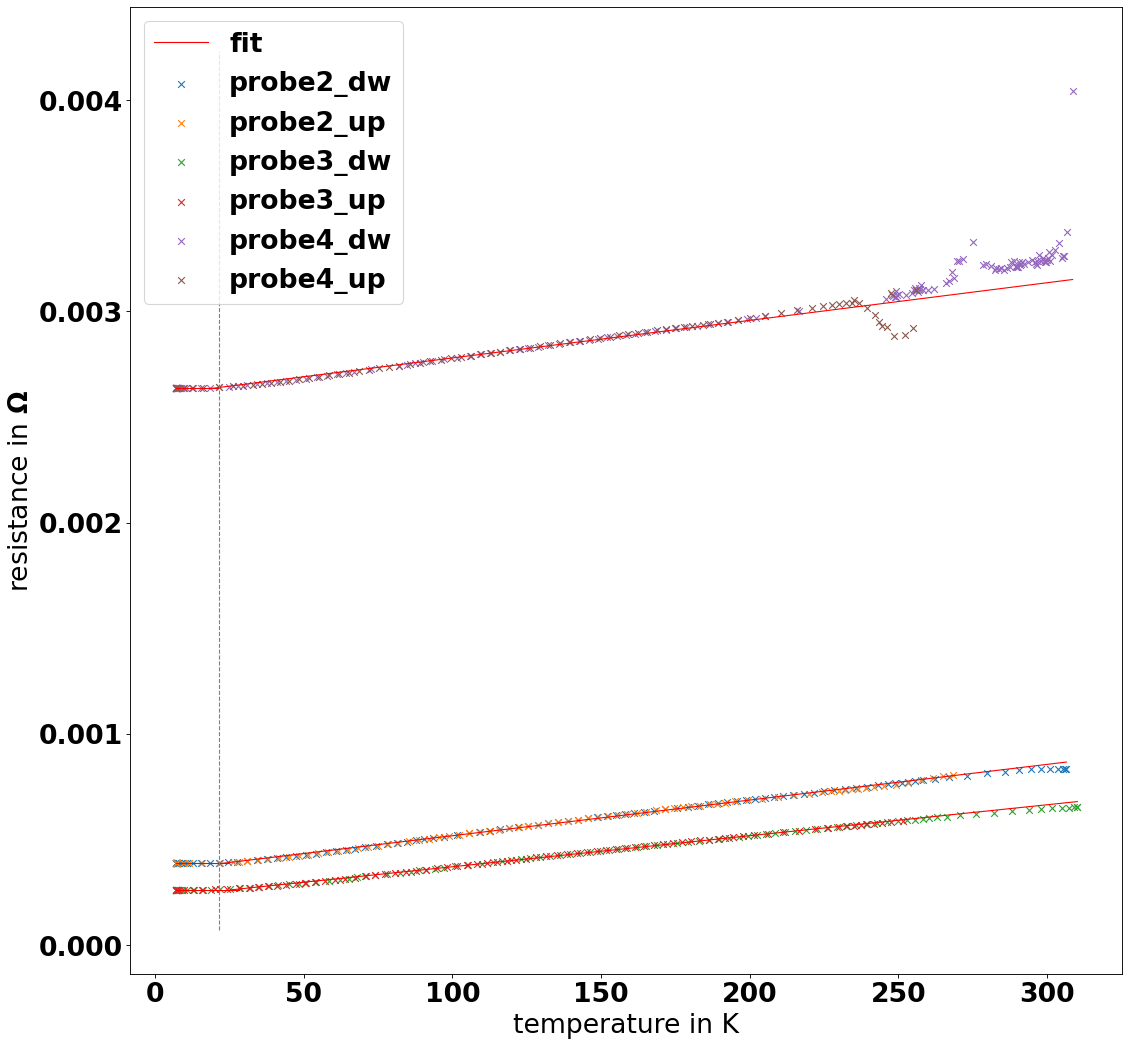

In [84]:
def f(x,a,b,c,d,e,f,g,h,i,j,k,l):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7 + i*x**8 + j*x**9 + k*x**10 + l*x**11

def f2(x,a):
    return a

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique),loc="upper left")



def res_elements(res,temp,name):
    er = []
    eT = []

    thresh = {'probe2_dw_min':0.7e-5,'probe2_dw_max':4.5e-5,
            'probe2_up_min':0.7e-5,'probe2_up_max':2e-5,
            'probe3_dw_min':0.7e-5,'probe3_dw_max':7e-5,
            'probe3_up_min':0.5e-5,'probe3_up_max':2e-5,
            'probe4_dw_min':0.7e-5,'probe4_dw_max':2e-5,
            'probe4_up_min':0.7e-5,'probe4_up_max':2e-5,}
    thresh_min = thresh[name+"_min"]
    thresh_max = thresh[name+"_max"]
    start = 0 
    stop = 0
    sold = 0

    dx = []
    for i in range(len(res)-1):
        dx.append(res[i]-res[i+1])
    
    for i in range(len(dx)):
       # print(abs(dx[i]))
        if abs(dx[i]) > thresh_min and abs(dx[i]) < thresh_max:
            if start == sold:
                start = i
            else:
                stop = i
                #print(start,stop)
                er.append(np.average(res[start:stop]))
                eT.append(np.average(temp[start:stop]))
                sold = start
                start = i
    
    r = []
    t = []
    for i in range(0,len(er)-1,2):
        r.append(1/2*(er[i]+er[i+1]))
        t.append(1/2*(eT[i]+eT[i+1]))
    
    return r,t

rdw = []
tdw = []

fig = plt.figure(figsize=(16,16),dpi=80)
fig.tight_layout(pad=0.5, w_pad=3.5, h_pad=3.5)
#fig.suptitle("Widerstandsmessung",size=30)

ax = fig.add_subplot(111)

for name in measurements:
    time = measurements[name][-1]
    resistance = measurements[name][-2]
    #voltage = measurements[name][-3]
    #current = measurements[name][-4]
    temperature = measurements[name][0]

    temp = []
    rtemp = []
    if temperature[0] > temperature[-1]:
        for i in range(len(temperature)):
            temp.append(temperature[-(i+1)])
            rtemp.append(resistance[-(i+1)])
        temperature = temp
        resistance = rtemp

    ax.set(xlabel="temperature in K",ylabel=r"resistance in $\Omega$")


    r,t = res_elements(resistance,temperature,name)
    index_l = 0
    index_h = 0
    for i in range(len(temperature)):
        if abs(temperature[i] - 50) < 1.5:
            #print("test",name,t[i])
            index_l = i
    for i in range(len(temperature)):
        if abs(temperature[i] - 250) < 4.5:
            #print("test",name,t[i])
            index_h = i
    if 'dw' in name:
        tdw = t
        rdw = r

    def f3(x,a,b):
        return a + x*b
    
    if 'up' in name:
        fit_temp = np.concatenate((tdw,t))
        fit_res = np.concatenate((rdw,r))

        fit_res = [x for _,x in sorted(zip(fit_temp,fit_res), key=lambda pair: pair[0])]
        fit_temp = sorted(fit_temp)


        index_fl = 0
        index_fh = 0
        for i in range(len(fit_temp)):
            if abs(fit_temp[i] - 50) < 1.5:
                #print("test",name,t[i])
                index_fl = i
        for i in range(len(fit_temp)):
            if abs(fit_temp[i] - 250) < 4.5:
                #print("test",name,t[i])
                index_fh = i


        indexf = 30
        popt, pcov = opt.curve_fit(f3,fit_temp[index_fl:index_fh],fit_res[index_fl:index_fh])
        print(name,popt)
        x = max(fit_temp)
        indexf = 0
        while f3(x,*popt) > f2(x,min(fit_res)):
            x = x - 0.1
        for i,te in enumerate(fit_temp):
            if te > x:
                indexf = i
                break

        ax.plot(fit_temp[indexf-1:],[f3(x,*popt) for x in fit_temp[indexf-1:]],color="red",label="fit",linewidth=1)
        ax.plot(fit_temp[:indexf+1],[f2(x,min(fit_res)) for x in fit_temp[:indexf+1]],color="red",label="fit",linewidth=1)
        print(np.mean(fit_res[:indexf+1]),np.std(fit_res[:indexf+1]))
        if '4' in name:
            ax.plot([fit_temp[indexf],fit_temp[indexf]],ax.get_ylim(),linestyle="--",color="grey",linewidth=1)
        #ax.scatter(fit_temp,fit_res,label="test")
    ax.scatter(t,r,label=name,linewidth=1,marker="x")
    #ax.annotate(min(r),(5,min(r)))
    #fig.legend()
    #ax.set_legend_handles_labels(test)

    
    legend_without_duplicate_labels(ax)
    #fig.legend()
    #print(test.set_label("pipipopo"))
    plt.savefig("Widerstand.pdf")
    #if 'up' in name:
    #    break


In [ ]:
fig = plt.figure(figsize=(16,16),dpi=80)
fig.tight_layout(pad=0.5, w_pad=3.5, h_pad=3.5)
#fig.suptitle("Spezifischer Widerstand",size=30)

ax = fig.add_subplot(111)

for name in measurements:
    time = measurements[name][-1]
    resistance = measurements[name][-2]
    #voltage = measurements[name][-3]
    #current = measurements[name][-4]
    temperature = measurements[name][0]

    temp = []
    rtemp = []
    if temperature[0] > temperature[-1]:
        for i in range(len(temperature)):
            temp.append(temperature[-(i+1)])
            rtemp.append(resistance[-(i+1)])
        temperature = temp
        resistance = rtemp

   # popt, pcov = opt.curve_fit(f,temperature,resistance)


    
    #ax = fig.add_subplot(321)
    #ax.scatter(time,temperature,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="temperature in K")

    #ax = fig.add_subplot(322)
    #ax.scatter(time,current,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="current in A")

    #ax = fig.add_subplot(323)
    #ax.scatter(time,voltage,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="voltage in V")

    #ax = fig.add_subplot(324)
    #ax.scatter(time,resistance,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel=r"resistance in $\Omega$")


    #ax.scatter(temperature,resistance,marker=".",s=1)
    ax.set(xlabel="temperature in K",ylabel=r"specific resistance in $\Omega \cdot m$")


    r,t = res_elements(resistance,temperature,name)
    for i,e in enumerate(r):
        r[i] = e*fl[name]
    index_l = 0
    index_h = 0
    for i in range(len(t)):
        if abs(t[i] - 50) < 1.5:
            #print("test",name,t[i])
            index_l = i
    for i in range(len(t)):
        if abs(t[i] - 250) < 4.5:
            #print("test",name,t[i])
            index_h = i

    if 'dw' in name:
        tdw = t
        rdw = r

    def f3(x,a,b):
        return a + x*b
    
    if 'up' in name:
        fit_temp = np.concatenate((tdw,t))
        fit_res = np.concatenate((rdw,r))

        fit_res = [x for _,x in sorted(zip(fit_temp,fit_res), key=lambda pair: pair[0])]
        fit_temp = sorted(fit_temp)


        index_fl = 0
        index_fh = 0
        for i in range(len(fit_temp)):
            if abs(fit_temp[i] - 50) < 1.5:
                #print("test",name,t[i])
                index_fl = i
        for i in range(len(fit_temp)):
            if abs(fit_temp[i] - 250) < 4.5:
                #print("test",name,t[i])
                index_fh = i


        indexf = 30
        popt, pcov = opt.curve_fit(f3,fit_temp[index_fl:index_fh],fit_res[index_fl:index_fh])
        #print(name,popt)
        x = max(fit_temp)
        indexf = 0
        while f3(x,*popt) > f2(x,min(fit_res)):
            x = x - 0.1
        for i,te in enumerate(fit_temp):
            if te > x:
                indexf = i
                break

        ax.plot(fit_temp[indexf-1:],[f3(x,*popt) for x in fit_temp[indexf-1:]],color="red",label="fit",linewidth=1)
        ax.plot(fit_temp[:indexf+1],[f2(x,min(fit_res)) for x in fit_temp[:indexf+1]],color="red",label="fit",linewidth=1)
        print(name,min(r))
        print(np.sqrt(pcov))
        if '4' in name:
            ax.plot([fit_temp[indexf],fit_temp[indexf]],ax.get_ylim(),linestyle="--",color="grey",linewidth=1)
    ax.scatter(t,r,label=name,marker="x",linewidth=1)
    #ax.annotate(min(r),(5,min(r))
    #fig.legend()
    #ax.set_legend_handles_labels(test)

    
    legend_without_duplicate_labels(ax)
    #fig.legend()
    #print(test.set_label("pipipopo"))
    plt.savefig("spezWiderstand.pdf")
    #break
